In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import sklearn

In [4]:
import xgboost as xgb

In [5]:
import catboost as ctb

In [6]:
import scipy

In [7]:
import tensorflow

In [8]:
import tensorflow.python.keras

In [13]:
!nvidia-smi

Wed Jan 25 14:21:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.36       Driver Version: 512.36       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   37C    P8    12W /  N/A |   1100MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
train=pd.read_excel('Discovery Set.xlsx',engine='openpyxl', header=1)

In [12]:
train.to_csv('cancer_data.csv',index=False)

In [12]:
train.shape

(1209, 145)

In [13]:
np.unique(train['Diagnoses'],return_counts=True)
#we nottice we are dealing with  unbalanced dataset

(array([0, 1], dtype=int64), array([291, 918], dtype=int64))

In [14]:
neg, pos = np.bincount(train['Diagnoses'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
#proportion of majority class meaning 1 is nearly 76%

Examples:
    Total: 1209
    Positive: 918 (75.93% of total)



In [15]:
train.dtypes

Diagnoses             int64
p.F115C               int64
p.M195V               int64
p.W3X                 int64
c.93delT              int64
                      ...  
p.Y214N               int64
c.1546insC            int64
c.1548insC            int64
p.Q514P               int64
c.2177_2178insCTAT    int64
Length: 145, dtype: object

In [16]:
#importing metrics
from sklearn.metrics import accuracy_score , balanced_accuracy_score , f1_score

In [17]:
#split into features space X and target y
y=train['Diagnoses']
X=train.drop('Diagnoses',axis=1)

In [18]:
 X

,p.F115C,p.M195V,p.W3X,c.93delT,p.W77X,p.V167M,p.F191L,p.R75Q,c.176del16bp,p.R143W,...,p.S28R,p.S49T,p.S93N,p.V233L,p.V670A,p.Y214N,c.1546insC,c.1548insC,p.Q514P,c.2177_2178insCTAT
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#FIXING THIS ISSUE :ValueError: could not convert string to float: ' '
for col in X.columns :
    X.loc[X[col] == ' ', col] = 0.0
    X[col]=X[col].astype(float)

# Xgboost modeling

In [20]:
#filling nan values if exist
X=X.fillna(0)

In [21]:
# evaluating xgboost model with default parameters  on 10 cross validations with  3 metrics most importantt is:
#f1 score and proportions of predictions
acc_score=[]
balanced_acc=[]
f1=[]
distro=[]
from sklearn.model_selection import train_test_split
for cross_val in range(10):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=np.random.randint(12345))
    model_xgb=xgb.XGBClassifier(tree_method='gpu_hist')
    model_xgb.fit(np.array(X_train.astype(float)),y_train)
    pred_xgb=model_xgb.predict(np.array(X_test))
    acc_score.append(accuracy_score(pred_xgb,y_test))
    balanced_acc.append(balanced_accuracy_score(pred_xgb,y_test))
    f1.append(f1_score(pred_xgb,y_test))
    neg, pos = np.bincount(pred_xgb)
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))
    distro.append(100*pos/total)
 

Examples:
    Total: 399
    Positive: 359 (89.97% of total)

Examples:
    Total: 399
    Positive: 350 (87.72% of total)

Examples:
    Total: 399
    Positive: 340 (85.21% of total)

Examples:
    Total: 399
    Positive: 357 (89.47% of total)

Examples:
    Total: 399
    Positive: 369 (92.48% of total)

Examples:
    Total: 399
    Positive: 338 (84.71% of total)

Examples:
    Total: 399
    Positive: 364 (91.23% of total)

Examples:
    Total: 399
    Positive: 370 (92.73% of total)

Examples:
    Total: 399
    Positive: 388 (97.24% of total)

Examples:
    Total: 399
    Positive: 354 (88.72% of total)



In [22]:
acc_score

[0.7393483709273183,
 0.7418546365914787,
 0.7769423558897243,
 0.7518796992481203,
 0.7619047619047619,
 0.7794486215538847,
 0.7493734335839599,
 0.7543859649122807,
 0.7368421052631579,
 0.7644110275689223]

In [23]:
balanced_acc

[0.6219011142061281,
 0.6334693877551021,
 0.6660019940179461,
 0.6512605042016807,
 0.6569105691056911,
 0.6682995440876904,
 0.6302197802197802,
 0.6768872320596458,
 0.6880271790065604,
 0.6247645951035781]

In [24]:
f1

[0.8414634146341463,
 0.8408037094281299,
 0.8628659476117103,
 0.8488549618320611,
 0.8584202682563338,
 0.8641975308641976,
 0.8493975903614458,
 0.852852852852853,
 0.8453608247422681,
 0.8584337349397589]

In [25]:
distro

[89.97493734335839,
 87.71929824561404,
 85.21303258145363,
 89.47368421052632,
 92.4812030075188,
 84.71177944862156,
 91.2280701754386,
 92.73182957393483,
 97.24310776942356,
 88.7218045112782]

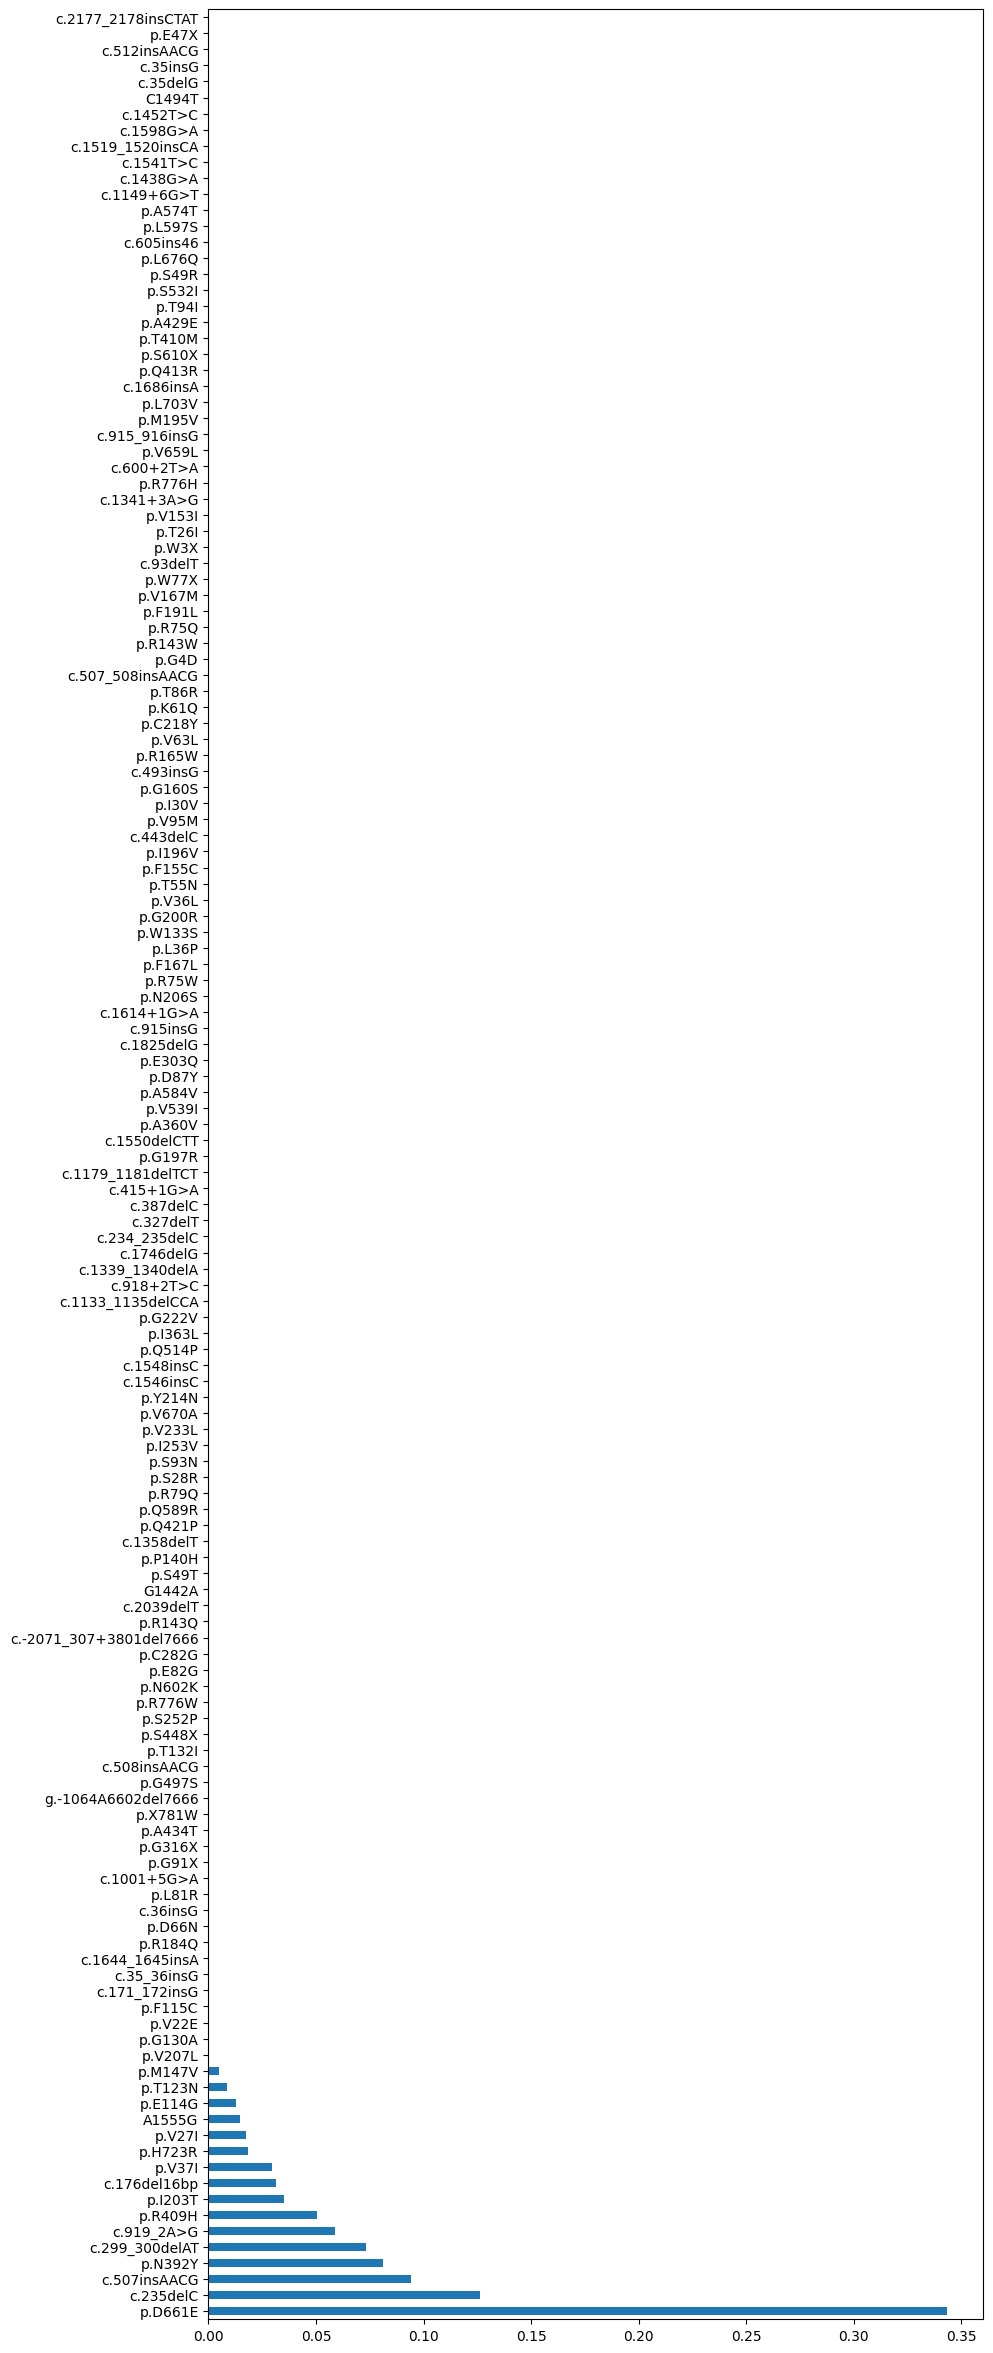

In [26]:
# Plot feature importance
import matplotlib 
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 30))
feat_importances = pd.Series(model_xgb.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False).plot(kind='barh')
plt.show()  

In [27]:
"""conclusions and some statistics """
# 1 
# average f1 score 
print(" avg f1 score ",np.mean(f1))
# standard deviation of f1 score 
print("standard dev f1 ",np.std(f1))
# 2
# proportion of  majority class is  76% and on this experiment most closer one is 80%
print(" avg distro",np.mean(distro))
print("distro deviation", np.std(distro))

 avg f1 score  0.8522650835522905
standard dev f1  0.008041175501024083
 avg distro 89.9498746867168
distro deviation 3.5434200505107305


In [28]:
""" Feature enginerring"""

' Feature enginerring'

In [29]:
train.corr(numeric_only=True)

,Diagnoses,p.F115C,p.M195V,p.W3X,c.93delT,p.W77X,p.V167M,p.F191L,p.R75Q,c.176del16bp,...,p.S28R,p.S49T,p.S93N,p.V233L,p.V670A,p.Y214N,c.1546insC,c.1548insC,p.Q514P,c.2177_2178insCTAT
Diagnoses,1.000000,0.022919,-0.068639,-0.015304,0.016199,0.016199,0.045951,-0.024014,0.016199,0.041153,...,0.016199,0.022919,-0.051102,0.016199,-0.024691,0.016199,0.016199,0.032439,0.022919,NaN
p.F115C,0.022919,1.000000,-0.002345,-0.002875,-0.001171,-0.001171,-0.003322,-0.002623,-0.001171,-0.008543,...,-0.001171,-0.001657,-0.001171,-0.001171,-0.001657,-0.001171,-0.001171,-0.002345,-0.001657,NaN
p.M195V,-0.068639,-0.002345,1.000000,-0.004069,-0.001658,-0.001658,-0.004702,-0.003713,-0.001658,-0.012091,...,-0.001658,-0.002345,-0.001658,-0.001658,-0.002345,-0.001658,-0.001658,-0.003320,-0.002345,NaN
p.W3X,-0.015304,-0.002875,-0.004069,1.000000,-0.002032,0.407403,-0.005764,-0.004551,-0.002032,-0.014821,...,-0.002032,-0.002875,-0.002032,-0.002032,-0.002875,-0.002032,-0.002032,-0.004069,-0.002875,NaN
c.93delT,0.016199,-0.001171,-0.001658,-0.002032,1.000000,-0.000828,-0.002348,-0.001854,-0.000828,-0.006038,...,-0.000828,-0.001171,-0.000828,-0.000828,-0.001171,-0.000828,-0.000828,-0.001658,-0.001171,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p.Y214N,0.016199,-0.001171,-0.001658,-0.002032,-0.000828,-0.000828,-0.002348,-0.001854,-0.000828,-0.006038,...,-0.000828,-0.001171,-0.000828,-0.000828,-0.001171,1.000000,-0.000828,-0.001658,-0.001171,NaN
c.1546insC,0.016199,-0.001171,-0.001658,-0.002032,-0.000828,-0.000828,-0.002348,-0.001854,-0.000828,-0.006038,...,-0.000828,-0.001171,-0.000828,-0.000828,-0.001171,-0.000828,1.000000,-0.001658,-0.001171,NaN
c.1548insC,0.032439,-0.002345,-0.003320,-0.004069,-0.001658,-0.001658,-0.004702,-0.003713,-0.001658,-0.012091,...,-0.001658,-0.002345,-0.001658,-0.001658,-0.002345,-0.001658,-0.001658,1.000000,0.352088,NaN
p.Q514P,0.022919,-0.001657,-0.002345,-0.002875,-0.001171,-0.001171,-0.003322,-0.002623,-0.001171,-0.008543,...,-0.001171,-0.001657,-0.001171,-0.001171,-0.001657,-0.001171,-0.001171,0.352088,1.000000,NaN


In [30]:
np.unique(train['c.2177_2178insCTAT'],return_counts=True)#zero variance so we drop it

(array([0], dtype=int64), array([1209], dtype=int64))

In [31]:
X=X.drop('c.2177_2178insCTAT',axis=1)

In [32]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X.fillna(-13))
kmeans_=kmeans.transform(X.fillna(-13))
X['kmeans1']=kmeans_[:,0] 
X['kmeans2']=kmeans_[:,1] 
X['kmeans3']=kmeans_[:,2] 

C:\Users\AlexandruDaia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [33]:
from sklearn.decomposition import PCA
pca = PCA(0.99)
pca_=pca.fit_transform(X.fillna(-13))
pca_

array([[-6.16219686e-01, -1.14823846e+00,  7.35074261e-02, ...,
         5.48606299e-17, -2.41099458e-16,  1.68701858e-16],
       [-6.16219686e-01, -1.14823846e+00,  7.35074261e-02, ...,
         2.68882139e-17, -2.18087267e-16,  1.34874750e-16],
       [-6.16219686e-01, -1.14823846e+00,  7.35074261e-02, ...,
         4.23923049e-17, -2.26571149e-16,  1.58727198e-16],
       ...,
       [ 1.06550901e+00,  1.34591662e-01, -1.89793720e-01, ...,
        -8.93247065e-17, -3.31223764e-17, -1.03554860e-16],
       [ 1.25322030e+00, -7.92833562e-02, -8.63738762e-01, ...,
        -1.22569056e-16,  5.32343267e-16,  5.83626029e-16],
       [-6.02485332e-01, -4.67980608e-01,  3.49956725e-01, ...,
        -8.70614345e-17, -1.68674753e-16, -2.14238349e-16]])

In [34]:
X['pca1']=pca_[:,0]
X['pca2']=pca_[:,1]
X['pca3']=pca_[:,3]

In [35]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3, learning_rate='auto',init='random', perplexity=3).fit_transform(X.fillna(-13))
X['manifold1']=X_embedded[:,0]
X['manifold2']=X_embedded[:,1]
X['manifold3']=X_embedded[:,2]

In [36]:
def  kin_energy(random_vec):
    """return    kinetic  energy  of   random vector represented   of   (1,) dimmensional  array"""
    freq=np.unique(random_vec,return_counts=True)
    prob=freq[1]/random_vec.shape[0]
    energy=np.sum(prob**2)
    return  energy

In [37]:
X['kinetic_energy']=X.apply(kin_energy,axis=1)

In [38]:
X['row_sum']=X.apply(np.sum,axis=1)

In [39]:
X.head(3)

,p.F115C,p.M195V,p.W3X,c.93delT,p.W77X,p.V167M,p.F191L,p.R75Q,c.176del16bp,p.R143W,...,kmeans2,kmeans3,pca1,pca2,pca3,manifold1,manifold2,manifold3,kinetic_energy,row_sum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.740574,1.939758,-0.61622,-1.148238,0.52963,-4.046125,3.445791,-16.709143,0.873182,-12.268804
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.740574,1.939758,-0.61622,-1.148238,0.52963,-3.288237,6.282576,-16.897127,0.873182,-8.862116
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.740574,1.939758,-0.61622,-1.148238,0.52963,-0.651399,5.120661,-16.545582,0.873182,-7.035648


In [132]:
# evaluating xgboost model with default parameters  on 10 cross validations with  3 metrics most importantt is:
#f1 score and proportions of predictions
acc_score=[]
balanced_acc=[]
f1=[]
distro=[]
from sklearn.model_selection import train_test_split
for cross_val in range(10):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=np.random.randint(12345))
    model_xgb=xgb.XGBClassifier(tree_method='gpu_hist')
    model_xgb.fit(np.array(X_train.astype(float)),y_train)
    pred_xgb=model_xgb.predict(np.array(X_test))
    acc_score.append(accuracy_score(pred_xgb,y_test))
    balanced_acc.append(balanced_accuracy_score(pred_xgb,y_test))
    f1.append(f1_score(pred_xgb,y_test))
    neg, pos = np.bincount(pred_xgb)
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))
    distro.append(100*pos/total)
 

Examples:
    Total: 303
    Positive: 251 (82.84% of total)

Examples:
    Total: 303
    Positive: 251 (82.84% of total)

Examples:
    Total: 303
    Positive: 262 (86.47% of total)

Examples:
    Total: 303
    Positive: 245 (80.86% of total)

Examples:
    Total: 303
    Positive: 251 (82.84% of total)

Examples:
    Total: 303
    Positive: 254 (83.83% of total)

Examples:
    Total: 303
    Positive: 244 (80.53% of total)

Examples:
    Total: 303
    Positive: 241 (79.54% of total)

Examples:
    Total: 303
    Positive: 263 (86.80% of total)

Examples:
    Total: 303
    Positive: 243 (80.20% of total)



In [133]:
acc_score

[0.8118811881188119,
 0.7854785478547854,
 0.8085808580858086,
 0.768976897689769,
 0.8118811881188119,
 0.7722772277227723,
 0.8151815181518152,
 0.7986798679867987,
 0.7986798679867987,
 0.801980198019802]

In [134]:
f1

[0.8839103869653767,
 0.8643006263048018,
 0.8830645161290323,
 0.8478260869565216,
 0.8829568788501027,
 0.8528784648187633,
 0.8813559322033898,
 0.8676789587852495,
 0.8762677484787018,
 0.8717948717948718]

In [135]:
balanced_acc

[0.7111170701808152,
 0.7104275206864848,
 0.7350121020294172,
 0.7255453905700211,
 0.7263637756665645,
 0.7406395629117789,
 0.7567379827729925,
 0.7536474367554544,
 0.7356463878326996,
 0.7447530864197531]

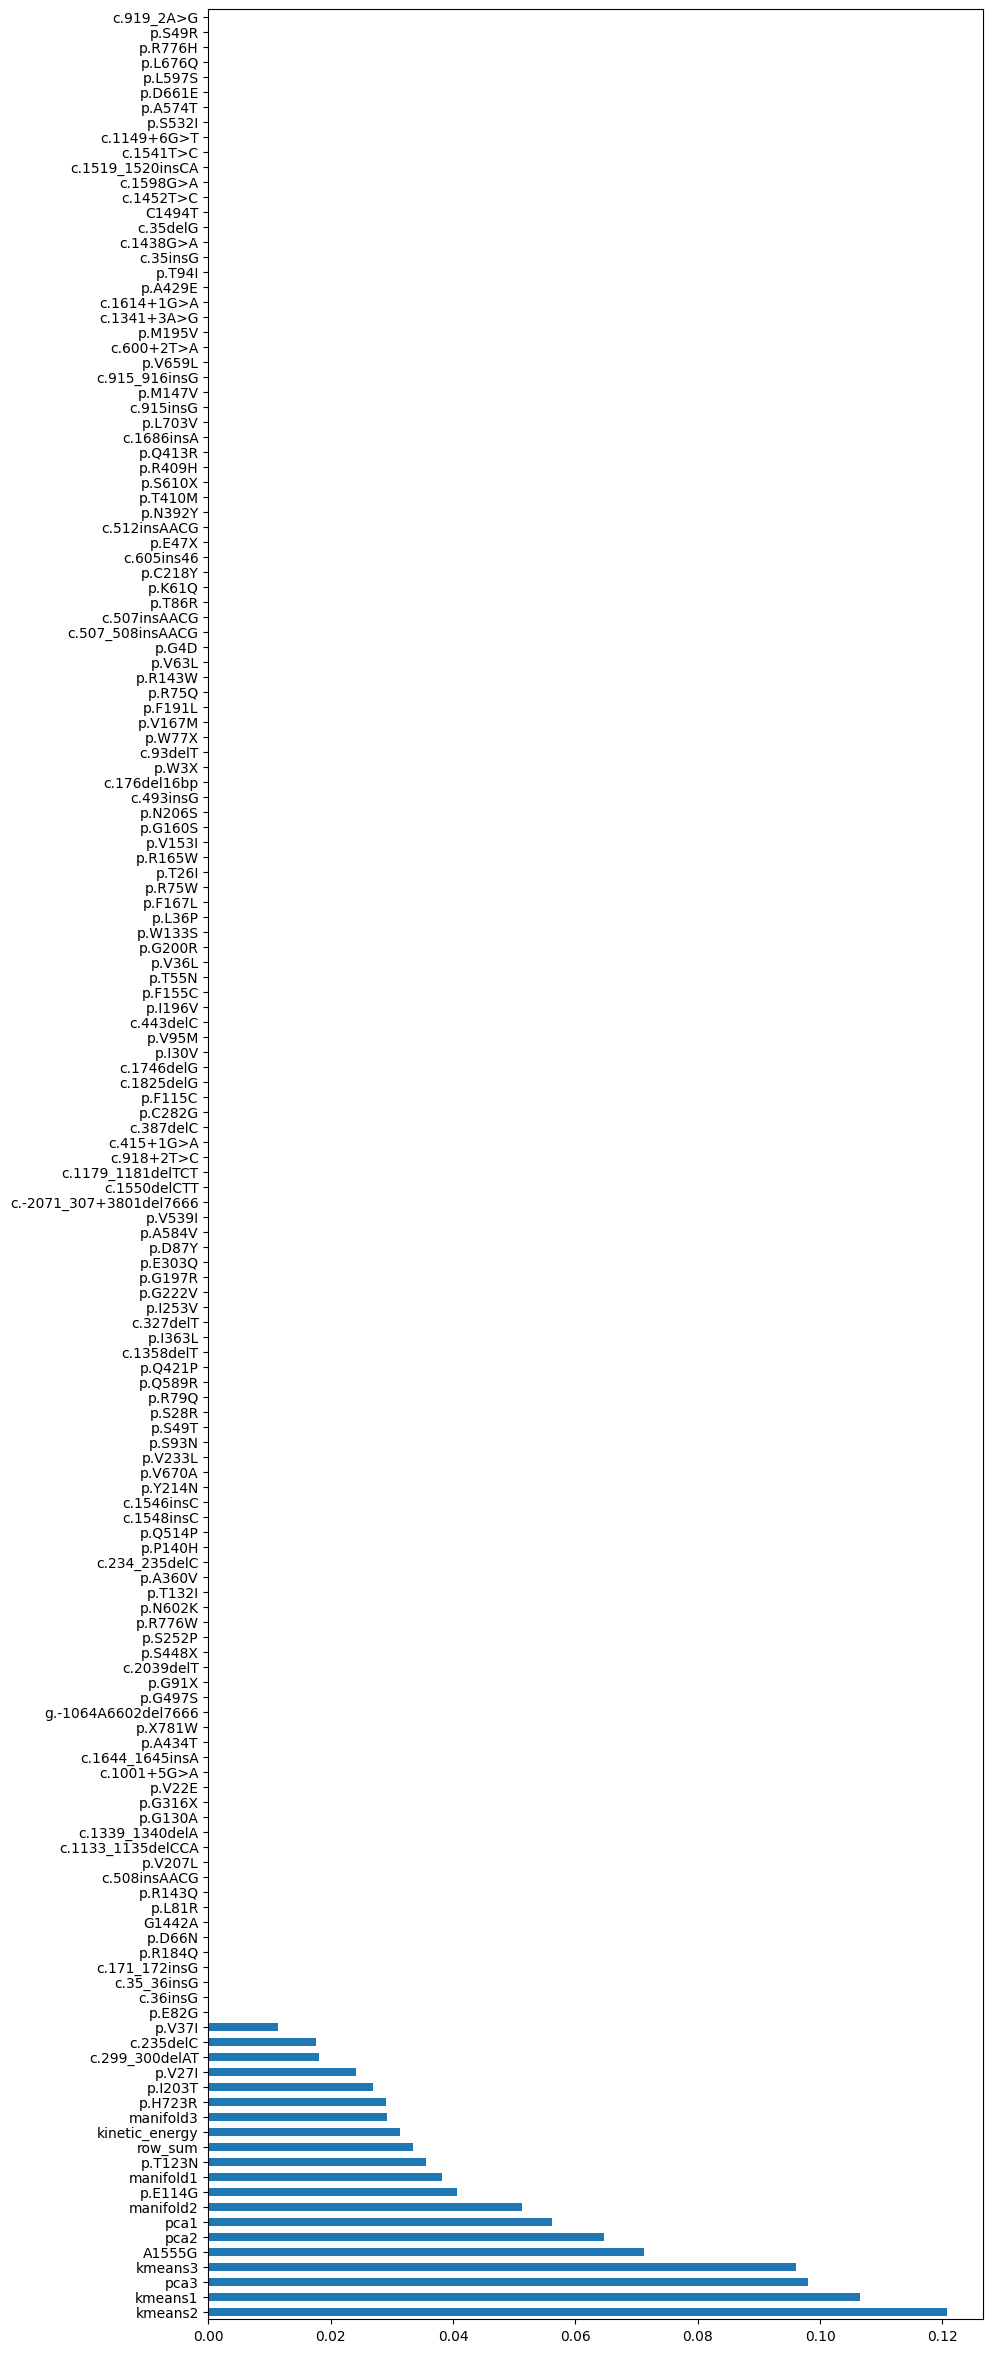

In [136]:
# Plot feature importance
plt.figure(figsize=(10, 30))
feat_importances = pd.Series(model_xgb.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False).plot(kind='barh')
plt.show()

In [137]:
"""conclusions and some statistics """
"""conclusions and some statistics """
# 1 
# average f1 score 
print(" avg f1 score ",np.mean(f1))
# standard deviation of f1 score 
print("standard dev f1 ",np.std(f1))
# 2
# proportion of  majority class is  76% and on this experiment most closer one is 78% 
# f1 scorer higher with feature engineering , but  standard dev increased
print(" avg distro",np.mean(distro))
print("distro deviation", np.std(distro))

 avg f1 score  0.8712034471286811
standard dev f1  0.012295288602768267
 avg distro 82.67326732673267
distro deviation 2.3810457406505283


    # Recursive feature elimination with cross-validation

In [43]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

min_features_to_select = 10 # Minimum number of features to consider
clf = LogisticRegression()
cv = StratifiedKFold(10)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="f1",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")

C:\Users\AlexandruDaia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\AlexandruDaia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

C:\Users\AlexandruDaia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\AlexandruDaia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

C:\Users\AlexandruDaia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\AlexandruDaia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

C:\Users\AlexandruDaia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\AlexandruDaia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

Optimal number of features: 43


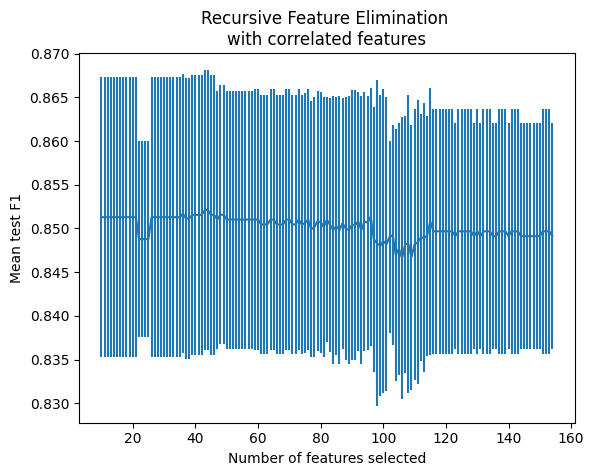

In [44]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test F1")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()


In [45]:
rfecv.feature_names_in_

array(['p.F115C', 'p.M195V', 'p.W3X', 'c.93delT', 'p.W77X', 'p.V167M',
       'p.F191L', 'p.R75Q', 'c.176del16bp', 'p.R143W', 'p.G4D',
       'c.507_508insAACG', 'c.507insAACG', 'c.299_300delAT', 'p.T86R',
       'p.T123N', 'c.235delC', 'p.I203T', 'p.E114G', 'p.V27I', 'p.K61Q',
       'p.C218Y', 'p.V63L', 'c.493insG', 'p.N206S', 'p.G160S', 'p.I30V',
       'p.V95M', 'c.443delC', 'p.I196V', 'p.F155C', 'p.T55N', 'p.V36L',
       'p.G200R', 'p.W133S', 'p.L36P', 'p.F167L', 'p.R75W', 'p.T26I',
       'p.R165W', 'p.V153I', 'c.605ins46', 'p.E47X', 'c.512insAACG',
       'c.35insG', 'c.35delG', 'p.V37I', 'C1494T', 'A1555G', 'c.1452T>C',
       'c.1598G>A', 'c.1519_1520insCA', 'c.1541T>C', 'c.1438G>A',
       'c.1149+6G>T', 'p.A574T', 'p.D661E', 'p.L597S', 'p.L676Q',
       'p.R776H', 'p.S49R', 'p.S532I', 'p.T94I', 'p.M147V', 'p.A429E',
       'p.T410M', 'p.S610X', 'p.R409H', 'p.Q413R', 'c.1686insA',
       'p.L703V', 'p.N392Y', 'c.915insG', 'c.915_916insG', 'p.V659L',
       'p.H723R', 'c.600+

In [46]:
#Version 1 with C=0.2
from sklearn.svm import LinearSVC
 
from sklearn.feature_selection import SelectFromModel
 
X.shape

lsvc = LinearSVC(C=0.02, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape
 

C:\Users\AlexandruDaia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(1209, 7)

In [47]:
model

SelectFromModel(estimator=LinearSVC(C=0.02, dual=False, penalty='l1'),
                prefit=True)

In [48]:
X_new

array([[  0.74057437,  -0.61621969,  -1.14823846, ...,  -4.04612494,
          3.44579124, -16.70914268],
       [  0.74057437,  -0.61621969,  -1.14823846, ...,  -3.28823709,
          6.28257608, -16.89712715],
       [  0.74057437,  -0.61621969,  -1.14823846, ...,  -0.65139878,
          5.12066078, -16.54558182],
       ...,
       [  1.67109597,   1.06550901,   0.13459166, ..., -19.00117493,
         -2.31666946,   7.31627846],
       [  1.34046425,   1.2532203 ,  -0.07928336, ..., -15.84390068,
         -0.70046091,   2.68777466],
       [  1.44204704,  -0.60248533,  -0.46798061, ...,  13.29291439,
         15.84961605,   2.0332334 ]])

In [49]:
subset1=model.get_feature_names_out(X.columns).tolist()
subset1

['kmeans2', 'pca1', 'pca2', 'pca3', 'manifold1', 'manifold2', 'manifold3']

In [50]:
# evaluating xgboost model with default parameters  on 10 cross validations with  3 metrics most importantt is:
#f1 score and proportions of predictions
acc_score=[]
balanced_acc=[]
f1=[]
distro=[]
from sklearn.model_selection import train_test_split
for cross_val in range(10):
    X_train, X_test, y_train, y_test = train_test_split( X[subset1], y, test_size=0.33, random_state=np.random.randint(12345))
    model_xgb=xgb.XGBClassifier(tree_method='gpu_hist')
    model_xgb.fit(np.array(X_train.astype(float)),y_train)
    pred_xgb=model_xgb.predict(np.array(X_test))
    acc_score.append(accuracy_score(pred_xgb,y_test))
    balanced_acc.append(balanced_accuracy_score(pred_xgb,y_test))
    f1.append(f1_score(pred_xgb,y_test))
    neg, pos = np.bincount(pred_xgb)
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))
    distro.append(100*pos/total)
 
 

Examples:
    Total: 399
    Positive: 339 (84.96% of total)

Examples:
    Total: 399
    Positive: 317 (79.45% of total)

Examples:
    Total: 399
    Positive: 326 (81.70% of total)

Examples:
    Total: 399
    Positive: 321 (80.45% of total)

Examples:
    Total: 399
    Positive: 337 (84.46% of total)

Examples:
    Total: 399
    Positive: 340 (85.21% of total)

Examples:
    Total: 399
    Positive: 334 (83.71% of total)

Examples:
    Total: 399
    Positive: 322 (80.70% of total)

Examples:
    Total: 399
    Positive: 315 (78.95% of total)

Examples:
    Total: 399
    Positive: 333 (83.46% of total)



In [51]:
f1

[0.8777429467084641,
 0.8594507269789984,
 0.8598726114649681,
 0.8757961783439491,
 0.8906009244992296,
 0.8781249999999998,
 0.879120879120879,
 0.8672000000000001,
 0.8618421052631579,
 0.8676236044657099]

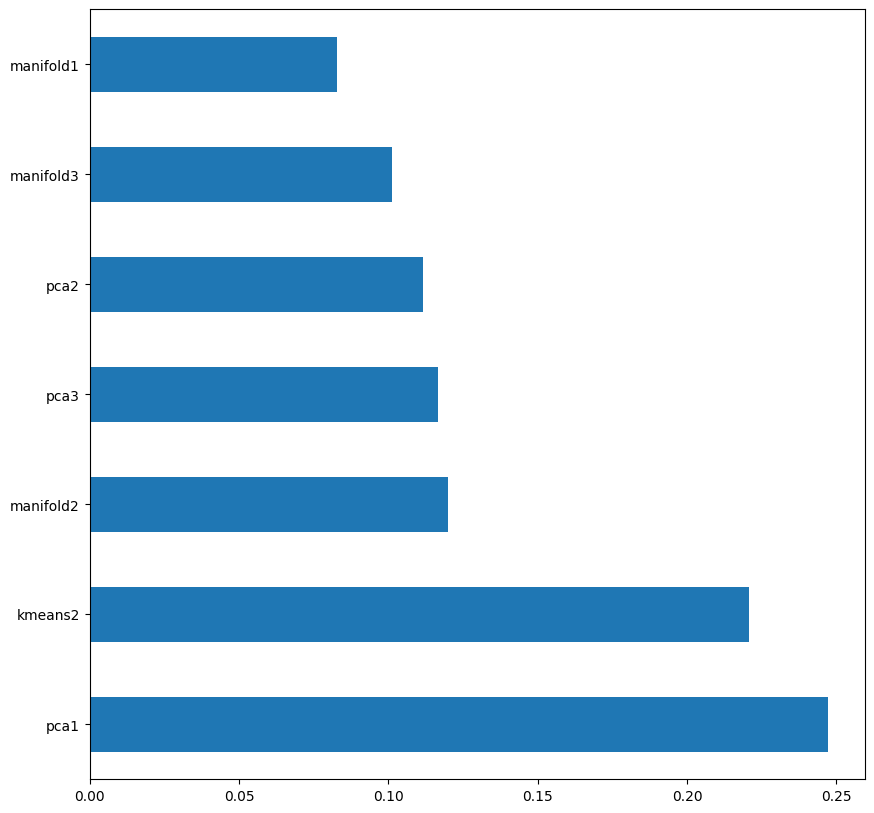

In [52]:
# Plot feature importance
plt.figure(figsize=(10, 10))
feat_importances = pd.Series(model_xgb.feature_importances_, index=X[subset1].columns)
feat_importances.sort_values(ascending=False).plot(kind='barh')
plt.show()

In [53]:
"""conclusions and some statistics """
"""conclusions and some statistics """
# 1 
# average f1 score 
print(" avg f1 score ",np.mean(f1))
# standard deviation of f1 score 
print("standard dev f1 ",np.std(f1))
# 2
# proportion of  majority class is  76% and on this experiment most closer one is 76% 
# f1 scorer lower with feature engineering and subseting , but  standard dev increased
print(" avg distro",np.mean(distro))
print("distro deviation", np.std(distro))

 avg f1 score  0.8717374976845356
standard dev f1  0.009648076172646408
 avg distro 82.30576441102758
distro deviation 2.219708253181407


In [54]:
#avg f1 score  0.8723737626553911
#standard dev f1  0.00986003642827118
# avg distro 81.45363408521304
#distro deviation 1.8245889446818329

In [55]:
#Version 2 with C=0.1
from sklearn.svm import LinearSVC
 
from sklearn.feature_selection import SelectFromModel
 
X.shape

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape
 

C:\Users\AlexandruDaia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(1209, 5)

In [56]:
subset2=model.get_feature_names_out(X.columns).tolist()
subset2

['kmeans2', 'pca1', 'manifold1', 'manifold2', 'row_sum']

In [60]:
# evaluating xgboost model with default parameters  on 10 cross validations with  3 metrics most importantt is:
#f1 score and proportions of predictions
acc_score=[]
balanced_acc=[]
f1=[]
distro=[]
from sklearn.model_selection import train_test_split
for cross_val in range(10):
    X_train, X_test, y_train, y_test = train_test_split( X[subset2], y, test_size=0.33, random_state=np.random.randint(12345))
    model_xgb=xgb.XGBClassifier(tree_method='gpu_hist')
    model_xgb.fit(np.array(X_train.astype(float)),y_train)
    pred_xgb=model_xgb.predict(np.array(X_test))
    acc_score.append(accuracy_score(pred_xgb,y_test))
    balanced_acc.append(balanced_accuracy_score(pred_xgb,y_test))
    f1.append(f1_score(pred_xgb,y_test))
    neg, pos = np.bincount(pred_xgb)
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))
    distro.append(100*pos/total)
 
 

Examples:
    Total: 399
    Positive: 322 (80.70% of total)

Examples:
    Total: 399
    Positive: 321 (80.45% of total)

Examples:
    Total: 399
    Positive: 330 (82.71% of total)

Examples:
    Total: 399
    Positive: 334 (83.71% of total)

Examples:
    Total: 399
    Positive: 326 (81.70% of total)

Examples:
    Total: 399
    Positive: 334 (83.71% of total)

Examples:
    Total: 399
    Positive: 311 (77.94% of total)

Examples:
    Total: 399
    Positive: 325 (81.45% of total)

Examples:
    Total: 399
    Positive: 328 (82.21% of total)

Examples:
    Total: 399
    Positive: 331 (82.96% of total)



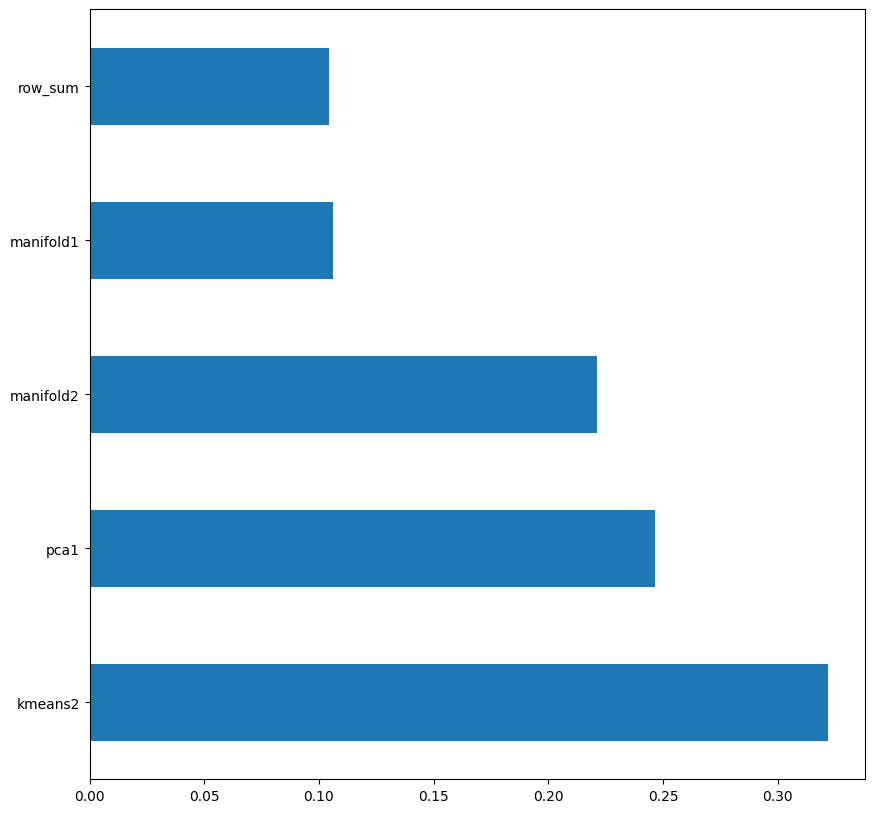

In [61]:
# Plot feature importance
plt.figure(figsize=(10, 10))
feat_importances = pd.Series(model_xgb.feature_importances_, index=X[subset2].columns)
feat_importances.sort_values(ascending=False).plot(kind='barh')
plt.show()

In [62]:
"""conclusions and some statistics """
"""conclusions and some statistics """
# 1 
# average f1 score 
print(" avg f1 score ",np.mean(f1))
# standard deviation of f1 score 
print("standard dev f1 ",np.std(f1))
# 2
# proportion of  majority class is  76% and on this experiment most closer one is 76% 
# f1 scorer lower with feature engineering and subseting2 , but  standard dev decreased so lower overfitting
print(" avg distro",np.mean(distro))
print("distro deviation", np.std(distro))

 avg f1 score  0.8683138010893469
standard dev f1  0.010014949893913544
 avg distro 81.75438596491229
distro deviation 1.6617127272431822


In [63]:
#avg f1 score  0.8723737626553911
#standard dev f1  0.00986003642827118
# avg distro 81.45363408521304
#distro deviation 1.8245889446818329

In [64]:
#Version 3 with C=0.1 and penalty l2
from sklearn.svm import LinearSVC
 
from sklearn.feature_selection import SelectFromModel
 
X.shape

lsvc = LinearSVC(C=0.01, penalty="l2", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape
 

C:\Users\AlexandruDaia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(1209, 44)

In [65]:
subset3=model.get_feature_names_out(X.columns).tolist()
subset3

['p.M195V',
 'p.F191L',
 'c.176del16bp',
 'p.G4D',
 'c.507_508insAACG',
 'c.507insAACG',
 'c.299_300delAT',
 'p.T123N',
 'c.235delC',
 'p.E114G',
 'p.V27I',
 'p.V63L',
 'p.I30V',
 'p.V37I',
 'A1555G',
 'p.A574T',
 'p.D661E',
 'p.S532I',
 'p.M147V',
 'p.S610X',
 'p.R409H',
 'p.N392Y',
 'c.915insG',
 'p.V659L',
 'c.919_2A>G',
 'c.35_36insG',
 'c.171_172insG',
 'c.2039delT',
 'c.1179_1181delTCT',
 'p.G197R',
 'p.I363L',
 'p.S93N',
 'c.1548insC',
 'kmeans1',
 'kmeans2',
 'kmeans3',
 'pca1',
 'pca2',
 'pca3',
 'manifold1',
 'manifold2',
 'manifold3',
 'kinetic_energy',
 'row_sum']

In [88]:
# evaluating xgboost model with default parameters  on 10 cross validations with  3 metrics most importantt is:
#f1 score and proportions of predictions
acc_score=[]
balanced_acc=[]
f1=[]
 
from sklearn.model_selection import train_test_split
for cross_val in range(10):
    X_train, X_test, y_train, y_test = train_test_split( X[subset3], y, test_size=0.33, random_state=np.random.randint(12345))
    model_xgb_best=xgb.XGBClassifier(tree_method='gpu_hist')
    model_xgb_best.fit(np.array(X_train.astype(float)),y_train)
    pred_xgb=model_xgb_best.predict(np.array(X_test))
    acc_score.append(accuracy_score(pred_xgb,y_test))
    balanced_acc.append(balanced_accuracy_score(pred_xgb,y_test))
    f1.append(f1_score(pred_xgb,y_test))
    neg, pos = np.bincount(pred_xgb)
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))
 

Examples:
    Total: 399
    Positive: 318 (79.70% of total)

Examples:
    Total: 399
    Positive: 313 (78.45% of total)

Examples:
    Total: 399
    Positive: 326 (81.70% of total)

Examples:
    Total: 399
    Positive: 328 (82.21% of total)

Examples:
    Total: 399
    Positive: 325 (81.45% of total)

Examples:
    Total: 399
    Positive: 326 (81.70% of total)

Examples:
    Total: 399
    Positive: 335 (83.96% of total)

Examples:
    Total: 399
    Positive: 312 (78.20% of total)

Examples:
    Total: 399
    Positive: 327 (81.95% of total)

Examples:
    Total: 399
    Positive: 332 (83.21% of total)



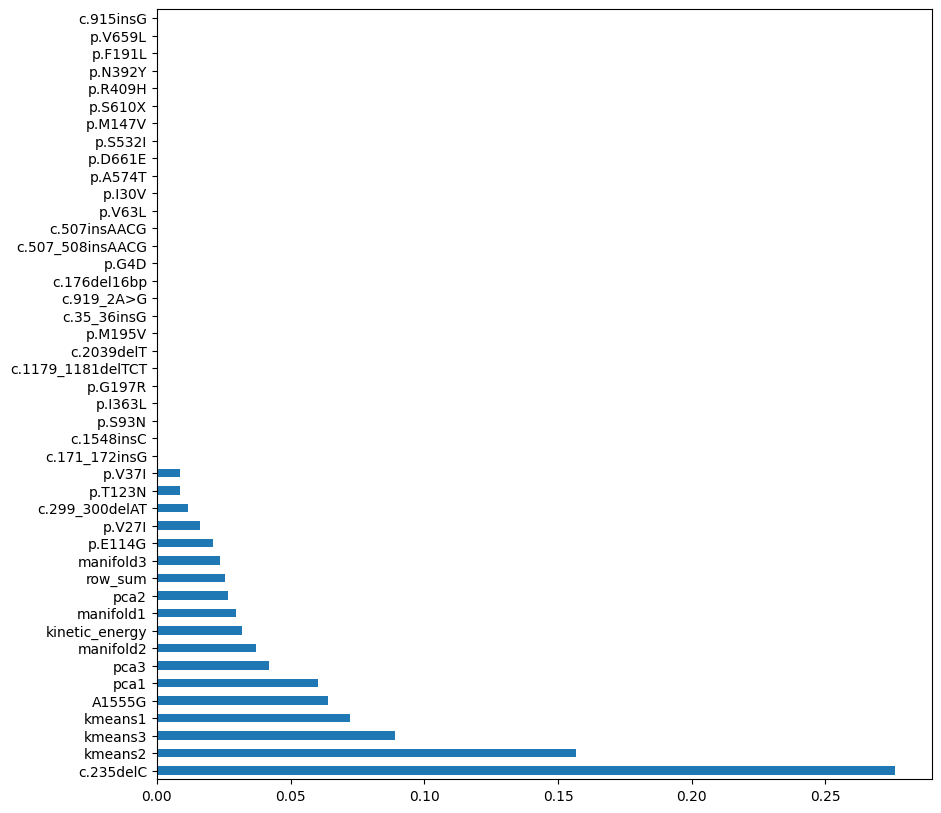

In [90]:
# Plot feature importance
plt.figure(figsize=(10, 10))
feat_importances = pd.Series(model_xgb_best.feature_importances_, index=X[subset3].columns)
feat_importances.sort_values(ascending=False).plot(kind='barh')
plt.show()

In [91]:
"""conclusions and some statistics """
"""conclusions and some statistics """
# 1 
# average f1 score 
print(" avg f1 score ",np.mean(f1))
# standard deviation of f1 score 
print("standard dev f1 ",np.std(f1))
# 2
# proportion of  majority class is  76% and on this experiment most closer one is 78% 
# f1 scorer lower with feature engineering and subseting2 , but  standard dev  higher

 avg f1 score  0.867626944034096
standard dev f1  0.006757619445357864


In [92]:
print(" avg distro",np.mean(distro))
print("distro deviation", np.std(distro))

 avg distro 83.7844611528822
distro deviation 1.7365726517614035


In [74]:
f1

[0.8761904761904761,
 0.8748019017432648,
 0.8677419354838709,
 0.8514851485148515,
 0.86984126984127,
 0.8670886075949367,
 0.87758346581876,
 0.8751974723538705,
 0.8478964401294498,
 0.8653846153846153]

# Catboost modeling

In [75]:
# evaluating catboost model with default parameters  on 10 cross validations with  3 metrics most importantt is:
#f1 score and proportions of predictions
acc_score=[]
balanced_acc=[]
f1=[]
distro=[]
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=np.random.randint(10000))
    import catboost as cb
    from catboost import Pool
    train_pool = Pool(X_train, y_train)
    eval_pool = Pool(X_test, y_test)
    model=cb.CatBoostClassifier(verbose=500 )
    model.fit(X_train,y_train,eval_set=eval_pool, early_stopping_rounds=20)
    pred=model.predict(X_test)
    acc_score.append(accuracy_score(pred,y_test))
    balanced_acc.append(balanced_accuracy_score(pred,y_test))
    f1.append(f1_score(pred,y_test))
    neg, pos = np.bincount(pred)
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))
    distro.append(100*pos/total)

Learning rate set to 0.030082
0:	learn: 0.6771360	test: 0.6762328	best: 0.6762328 (0)	total: 164ms	remaining: 2m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3953304427
bestIteration = 266

Shrink model to first 267 iterations.
Examples:
    Total: 399
    Positive: 343 (85.96% of total)

Learning rate set to 0.030082
0:	learn: 0.6707529	test: 0.6721405	best: 0.6721405 (0)	total: 1.92ms	remaining: 1.92s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4226787986
bestIteration = 162

Shrink model to first 163 iterations.
Examples:
    Total: 399
    Positive: 337 (84.46% of total)

Learning rate set to 0.030082
0:	learn: 0.6753215	test: 0.6749871	best: 0.6749871 (0)	total: 2.13ms	remaining: 2.13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3795554596
bestIteration = 250

Shrink model to first 251 iterations.
Examples:
    Total: 399
    Positive: 336 (84.21% of total)

Learning rate set to 0.030082
0:	learn: 0.6740949

In [77]:
f1

[0.8936825885978429,
 0.8805031446540881,
 0.9015384615384615,
 0.8860759493670886,
 0.8972809667673716,
 0.9036144578313253,
 0.8996960486322189,
 0.884080370942813,
 0.8962264150943396,
 0.882442748091603]

In [78]:
distro

[85.96491228070175,
 84.46115288220551,
 84.21052631578948,
 82.95739348370927,
 88.22055137844612,
 87.468671679198,
 89.47368421052632,
 86.71679197994987,
 84.9624060150376,
 87.71929824561404]

In [79]:
"""conclusions and some statistics """
"""conclusions and some statistics """
# 1 
# average f1 score 
print(" avg f1 score ",np.mean(f1))
# standard deviation of f1 score 
print("standard dev f1 ",np.std(f1))
# 2
# proportion of  majority class is  76% and on this experiment most closer one is 76% 
# f1 scorer lower with feature engineering and subseting , but  standard dev increased
print(" avg distro",np.mean(distro))
print("distro deviation", np.std(distro))

 avg f1 score  0.8925141151517151
standard dev f1  0.00807700344200154
 avg distro 86.2155388471178
distro deviation 1.9510276146394556


Text(0.5, 1.0, 'Feature Importance')

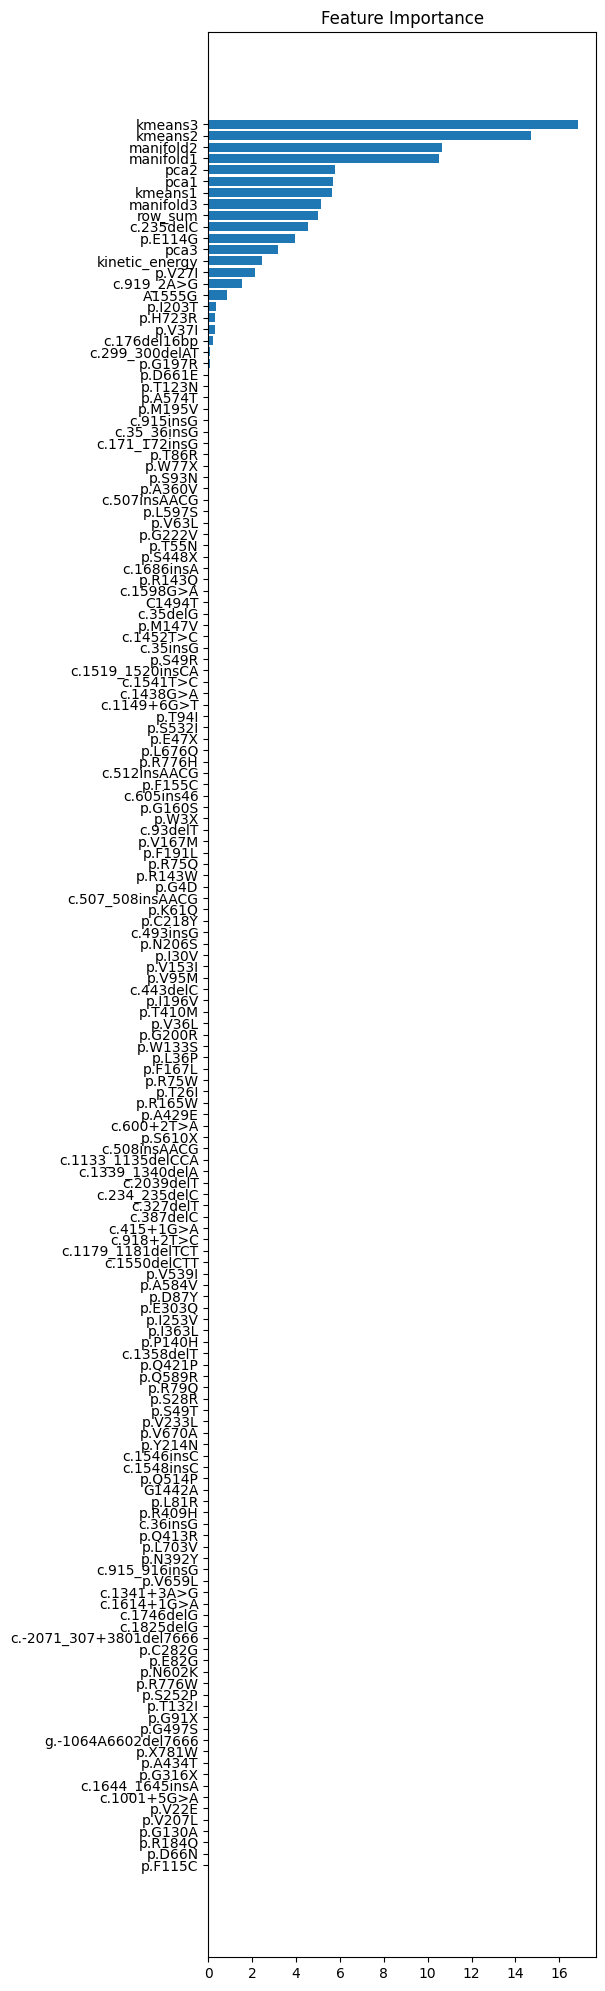

In [80]:
from matplotlib import pyplot as plt
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(5, 25))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [81]:
# evaluating catboost model with default parameters  on 10 cross validations with  3 metrics most importantt is:
#f1 score and proportions of predictions
acc_score=[]
balanced_acc=[]
f1=[]
distro=[]
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split( X[subset2], y, test_size=0.33, random_state=np.random.randint(10000))
    import catboost as cb
    from catboost import Pool
    train_pool = Pool(X_train, y_train)
    eval_pool = Pool(X_test, y_test)
    model=cb.CatBoostClassifier(verbose=500 )
    model.fit(X_train,y_train,eval_set=eval_pool, early_stopping_rounds=20)
    pred=model.predict(X_test)
    acc_score.append(accuracy_score(pred,y_test))
    balanced_acc.append(balanced_accuracy_score(pred,y_test))
    f1.append(f1_score(pred,y_test))
    neg, pos = np.bincount(pred)
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))
    distro.append(100*pos/total)

Learning rate set to 0.030082
0:	learn: 0.6728120	test: 0.6735057	best: 0.6735057 (0)	total: 1.68ms	remaining: 1.68s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4434790771
bestIteration = 88

Shrink model to first 89 iterations.
Examples:
    Total: 399
    Positive: 357 (89.47% of total)

Learning rate set to 0.030082
0:	learn: 0.6754979	test: 0.6779396	best: 0.6779396 (0)	total: 1.46ms	remaining: 1.46s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4485447249
bestIteration = 90

Shrink model to first 91 iterations.
Examples:
    Total: 399
    Positive: 350 (87.72% of total)

Learning rate set to 0.030082
0:	learn: 0.6762972	test: 0.6771038	best: 0.6771038 (0)	total: 1.46ms	remaining: 1.45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4297629958
bestIteration = 121

Shrink model to first 122 iterations.
Examples:
    Total: 399
    Positive: 333 (83.46% of total)

Learning rate set to 0.030082
0:	learn: 0.6702407	tes

Text(0.5, 1.0, 'Feature Importance')

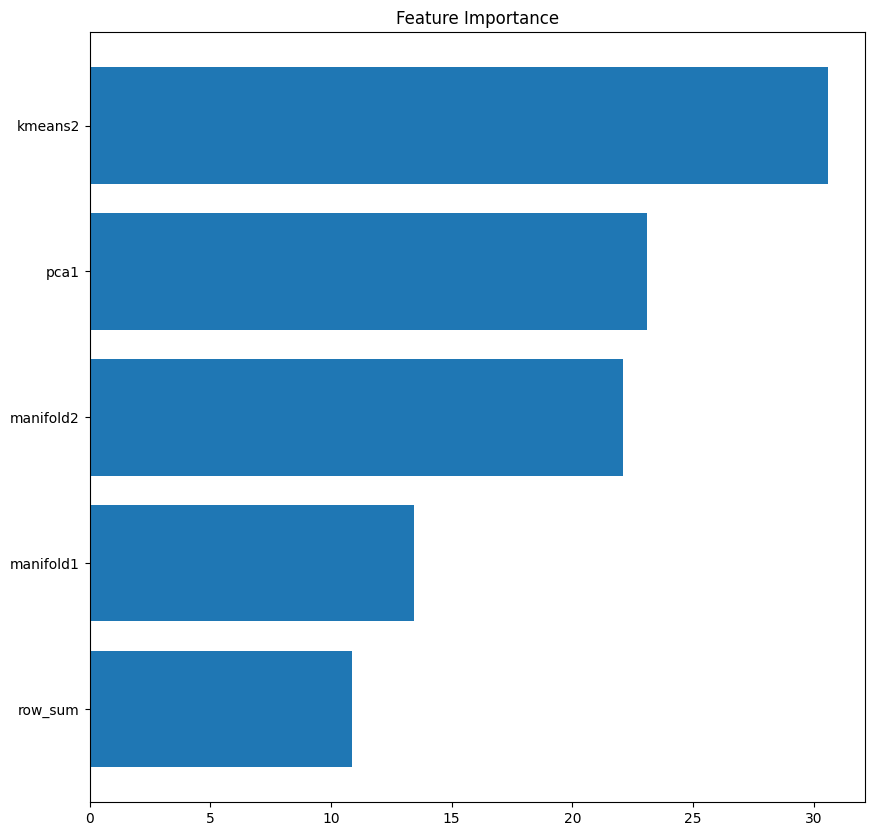

In [82]:
from matplotlib import pyplot as plt
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 10 ))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [83]:
"""conclusions and some statistics """
"""conclusions and some statistics """
# 1 
# average f1 score 
print(" avg f1 score ",np.mean(f1))
# standard deviation of f1 score 
print("standard dev f1 ",np.std(f1))
# 2
# proportion of  majority class is  76% and on this experiment most closer one is 76% 
# f1 scorer lower with feature engineering and subseting , but  standard dev increased
print(" avg distro",np.mean(distro))
print("distro deviation", np.std(distro))

 avg f1 score  0.8877803375006483
standard dev f1  0.010359456871263715
 avg distro 87.94486215538848
distro deviation 1.7344010302552317


In [ ]:
#avg f1 score  0.8723737626553911
#standard dev f1  0.00986003642827118
# avg distro 81.45363408521304
#distro deviation 1.8245889446818329

# Averaging one catboost and one  xgb

In [84]:
# evaluating catboost model with default parameters  on 10 cross validations with  3 metrics most importantt is:
#f1 score and proportions of predictions
acc_score=[]
balanced_acc=[]
f1=[]
distro=[]
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split( X[subset1], y, test_size=0.33, random_state=np.random.randint(10000))
      #catboost model
    import catboost as cb
    from catboost import Pool
    train_pool = Pool(X_train, y_train)
    eval_pool = Pool(X_test, y_test)
    model=cb.CatBoostClassifier(verbose=500 )
    model.fit(X_train,y_train,eval_set=eval_pool, early_stopping_rounds=20)
    pred1=model.predict_proba(X_test)
      #xgboost model 
    model_xgb=xgb.XGBClassifier(tree_method='gpu_hist')
    model_xgb.fit(np.array(X_train.astype(float)),y_train)
    pred_xgb=model_xgb.predict_proba(np.array(X_test))
    pred=np.argmax((pred1+pred_xgb)/2,axis=1)
    acc_score.append(accuracy_score(pred,y_test))
    balanced_acc.append(balanced_accuracy_score(pred,y_test))
    f1.append(f1_score(pred,y_test))
    neg, pos = np.bincount(pred)
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))
    distro.append(100*pos/total)

Learning rate set to 0.030082
0:	learn: 0.6771101	test: 0.6753825	best: 0.6753825 (0)	total: 1.61ms	remaining: 1.61s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3709203864
bestIteration = 121

Shrink model to first 122 iterations.
Examples:
    Total: 399
    Positive: 334 (83.71% of total)

Learning rate set to 0.030082
0:	learn: 0.6740241	test: 0.6750074	best: 0.6750074 (0)	total: 1.63ms	remaining: 1.63s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4099526637
bestIteration = 130

Shrink model to first 131 iterations.
Examples:
    Total: 399
    Positive: 334 (83.71% of total)

Learning rate set to 0.030082
0:	learn: 0.6737176	test: 0.6739015	best: 0.6739015 (0)	total: 1.61ms	remaining: 1.61s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3941572502
bestIteration = 114

Shrink model to first 115 iterations.
Examples:
    Total: 399
    Positive: 316 (79.20% of total)

Learning rate set to 0.030082
0:	learn: 0.6718634

In [85]:
f1

[0.8967642526964561,
 0.8794992175273866,
 0.8846153846153846,
 0.8672839506172838,
 0.853582554517134,
 0.893353941267388,
 0.8707692307692309,
 0.873634945397816,
 0.8871473354231976,
 0.8954758190327613]

In [86]:
distro

[83.70927318295739,
 83.70927318295739,
 79.19799498746868,
 85.71428571428571,
 83.95989974937343,
 83.70927318295739,
 84.46115288220551,
 85.46365914786968,
 84.9624060150376,
 82.95739348370927]

In [87]:
"""conclusions and some statistics """
"""conclusions and some statistics """
# 1 
# average f1 score 
print(" avg f1 score ",np.mean(f1))
# standard deviation of f1 score 
print("standard dev f1 ",np.std(f1))
# 2
# proportion of  majority class is  76% and on this experiment most closer one is 76% 
# f1 scorer lower with feature engineering and subseting , but  standard dev increased
print(" avg distro",np.mean(distro))
print("distro deviation", np.std(distro))

 avg f1 score  0.880212663186404
standard dev f1  0.01325275048651643
 avg distro 83.7844611528822
distro deviation 1.7365726517614035


In [104]:
#avg f1 score  0.8723737626553911
#standard dev f1  0.00986003642827118
# avg distro 81.45363408521304
#distro deviation 1.8245889446818329

# Lightgbm modeling and averaging with xgb
    
    

In [93]:
import lightgbm as ltb
    

In [94]:
# evaluating xgboost model with default parameters  on 10 cross validations with  3 metrics most importantt is:
#f1 score and proportions of predictions
acc_score=[]
balanced_acc=[]
f1=[]
distro=[]
from sklearn.model_selection import train_test_split
for cross_val in range(10):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=np.random.randint(12345))
    model_lgb= ltb.LGBMClassifier()
    
        
    model_lgb.fit(np.array(X_train.astype(float)),y_train)
    pred_lgb=model_lgb.predict(np.array(X_test))
    acc_score.append(accuracy_score(pred_lgb,y_test))
    balanced_acc.append(balanced_accuracy_score(pred_lgb,y_test))
    f1.append(f1_score(pred_lgb,y_test))
    neg, pos = np.bincount(pred_lgb)
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))
    distro.append(100*pos/total)
 

Examples:
    Total: 399
    Positive: 343 (85.96% of total)

Examples:
    Total: 399
    Positive: 336 (84.21% of total)

Examples:
    Total: 399
    Positive: 332 (83.21% of total)

Examples:
    Total: 399
    Positive: 312 (78.20% of total)

Examples:
    Total: 399
    Positive: 327 (81.95% of total)

Examples:
    Total: 399
    Positive: 328 (82.21% of total)

Examples:
    Total: 399
    Positive: 317 (79.45% of total)

Examples:
    Total: 399
    Positive: 329 (82.46% of total)

Examples:
    Total: 399
    Positive: 344 (86.22% of total)

Examples:
    Total: 399
    Positive: 322 (80.70% of total)



In [95]:
"""conclusions and some statistics """
"""conclusions and some statistics """
# 1 
# average f1 score 
print(" avg f1 score ",np.mean(f1))
# standard deviation of f1 score 
print("standard dev f1 ",np.std(f1))
# 2
# proportion of  majority class is  76% and on this experiment most closer one is 76% 
# f1 scorer lower with feature engineering and subseting , but  standard dev increased
print(" avg distro",np.mean(distro))
print("distro deviation", np.std(distro))

 avg f1 score  0.8708351422557332
standard dev f1  0.007913011170185178
 avg distro 82.45614035087719
distro deviation 2.4632907018156636


In [96]:
#avg f1 score  0.8723737626553911
#standard dev f1  0.00986003642827118
# avg distro 81.45363408521304
#distro deviation 1.8245889446818329

In [97]:
distro

[85.96491228070175,
 84.21052631578948,
 83.20802005012531,
 78.19548872180451,
 81.95488721804512,
 82.20551378446115,
 79.4486215538847,
 82.45614035087719,
 86.2155388471178,
 80.70175438596492]

In [98]:
f1

[0.8755760368663594,
 0.8785046728971961,
 0.8643533123028392,
 0.8747967479674796,
 0.8599033816425121,
 0.8767999999999999,
 0.8552845528455284,
 0.8684627575277337,
 0.8770864946889226,
 0.8775834658187599]

In [99]:
####################################Evaluating on an independent dataset ######################################################

In [100]:
train.shape

(1209, 145)

In [102]:
valid=pd.read_excel('validation.xlsx',engine='openpyxl', header=1)

In [103]:
valid.shape

(569, 145)

In [105]:
train.columns==valid.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [106]:
np.unique(valid['Diagnoses'],return_counts=True)
#we nottice we are dealing with  unbalanced dataset

(array([0, 1], dtype=int64), array([133, 436], dtype=int64))

In [112]:
neg, pos = np.bincount(valid['Diagnoses'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
#proportion of majority class meaning 1 is nearly 76%   samewith on train wich was 76%

Examples:
    Total: 569
    Positive: 436 (76.63% of total)



In [113]:
#split into features space X and target y
y_val=valid['Diagnoses']
val=valid.drop('Diagnoses',axis=1)

,p.F115C,p.M195V,p.W3X,c.93delT,p.W77X,p.V167M,p.F191L,p.R75Q,c.176del16bp,p.R143W,...,p.S28R,p.S49T,p.S93N,p.V233L,p.V670A,p.Y214N,c.1546insC,c.1548insC,p.Q514P,c.2177_2178insCTAT
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
#FIXING THIS ISSUE :ValueError: could not convert string to float: ' '
for col in val.columns :
    val.loc[val[col] == ' ', col] = 0.0
    val[col]=val[col].astype(float)

In [116]:
#filling nan values if exist
val=val.fillna(0)

In [117]:
np.unique(val['c.2177_2178insCTAT'],return_counts=True)#zero variance so we drop it

(array([0.]), array([569], dtype=int64))

In [118]:
val=val.drop('c.2177_2178insCTAT',axis=1)

In [119]:
#dealing wiht the festure engineering part same as we did on trainin dataset

In [120]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(val.fillna(-13))
kmeans_=kmeans.transform(val.fillna(-13))
val['kmeans1']=kmeans_[:,0] 
val['kmeans2']=kmeans_[:,1] 
val['kmeans3']=kmeans_[:,2] 

C:\Users\AlexandruDaia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [121]:
from sklearn.decomposition import PCA
pca = PCA(0.99)
pca_=pca.fit_transform(val.fillna(-13))
pca_

array([[-3.58280721e-01,  5.49085335e-01,  3.07466042e-01, ...,
         6.09167338e-03, -1.05145927e-15,  3.30464822e-16],
       [-4.14617751e-01,  6.33056603e-01, -1.73983908e-01, ...,
         1.38063148e-03, -3.34151110e-16,  2.38524478e-17],
       [ 1.04697187e+00,  4.47867239e-01,  1.26153378e-01, ...,
        -1.08998153e-03,  1.40295761e-15, -3.39463700e-16],
       ...,
       [-4.09716184e-01,  6.11450814e-01, -2.81203057e-01, ...,
        -1.03727578e-03,  1.76291273e-16, -1.10371781e-16],
       [-1.16286363e+00, -2.86713197e-01, -1.31975944e-01, ...,
         1.89419120e-03,  4.81385765e-17, -1.39211559e-16],
       [ 1.34106274e+00, -1.94399054e-01, -7.00619247e-01, ...,
        -3.17474161e-03,  1.33032962e-15, -2.64111649e-16]])

In [122]:
val['pca1']=pca_[:,0]
val['pca2']=pca_[:,1]
val['pca3']=pca_[:,3]

In [123]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3, learning_rate='auto',init='random', perplexity=3).fit_transform(val.fillna(-13))
val['manifold1']=X_embedded[:,0]
val['manifold2']=X_embedded[:,1]
val['manifold3']=X_embedded[:,2]

In [124]:
def  kin_energy(random_vec):
    """return    kinetic  energy  of   random vector represented   of   (1,) dimmensional  array"""
    freq=np.unique(random_vec,return_counts=True)
    prob=freq[1]/random_vec.shape[0]
    energy=np.sum(prob**2)
    return  energy
val['kinetic_energy']=val.apply(kin_energy,axis=1)
val['row_sum']=val.apply(np.sum,axis=1)

In [125]:
val

,p.F115C,p.M195V,p.W3X,c.93delT,p.W77X,p.V167M,p.F191L,p.R75Q,c.176del16bp,p.R143W,...,kmeans2,kmeans3,pca1,pca2,pca3,manifold1,manifold2,manifold3,kinetic_energy,row_sum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.018003,1.969548,-0.358281,0.549085,0.949607,-24.393339,5.073809,-16.367668,0.861063,-26.243123
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.761986,1.696797,-0.414618,0.633057,0.766070,-13.199656,6.842431,1.898837,0.873182,2.938157
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.946001,2.145318,1.046972,0.447867,-0.714828,15.164188,7.947191,-19.254292,0.849117,13.036820
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.757403,0.402663,-1.391817,-0.375102,-0.135152,20.235838,-4.526710,8.379364,0.873182,27.424038
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.021995,1.024173,-1.198134,-0.368100,0.080767,29.258053,-3.348125,-6.562693,0.861063,25.334409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.218042,2.380185,1.248218,-0.290392,0.334069,-6.054944,22.097120,-13.595113,0.873182,12.290523
565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.946001,2.145318,1.046972,0.447867,-0.714828,14.885139,10.061862,-20.166239,0.849117,13.960494
566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.755107,1.689367,-0.409716,0.611451,0.638924,-25.928905,14.302742,-3.157400,0.873182,-7.516970
567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.993881,1.060378,-1.162864,-0.286713,0.248136,15.053770,-12.562659,15.471207,0.861063,24.168942


In [138]:
pred_val=model_xgb.predict(val)

In [140]:
print("f1 score val ", f1_score(pred_val,y_val))

f1 score val  0.7635524798154555


In [141]:
neg, pos = np.bincount(pred_val)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
#proportion of majority class meaning 1 is nearly 76%

Examples:
    Total: 569
    Positive: 431 (75.75% of total)



In [142]:
pred_best=model_xgb_best.predict(val[subset3])

In [143]:
print("f1 score val best ", f1_score(pred_best,y_val))

f1 score val best  0.7033492822966506


In [144]:
neg, pos = np.bincount(pred_best)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
#proportion of majority class meaning 1 is nearly 76%

Examples:
    Total: 569
    Positive: 400 (70.30% of total)



In [ ]:
#